In [1]:
import os
import numpy as np
import gym
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.callbacks import BaseCallback
from fmi_mlc import fmi_gym
from config import parameter as PARAMS

# ————————————————————————————————————————
# Preparar carpetas
# ————————————————————————————————————————
os.makedirs("logs", exist_ok=True)
os.makedirs("models", exist_ok=True)

# ————————————————————————————————————————
# Callback: registrar recompensa real paso a paso
# ————————————————————————————————————————
class StepRewardLogger(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.raw_rewards = []
        self.timesteps   = []

    def _on_step(self) -> bool:
        info = self.locals["infos"][0]
        raw_r = float(info.get("raw_reward", 0.0))
        self.raw_rewards.append(raw_r)
        self.timesteps.append(self.num_timesteps)
        return True

    def _on_training_end(self) -> None:
        np.savez(
            "logs/step_rewards_real.npz",
            timesteps   = np.array(self.timesteps,   dtype=np.int32),
            raw_rewards = np.array(self.raw_rewards, dtype=np.float32)
        )

# ————————————————————————————————————————
# Wrapper: recompensa real = –sum(|PMV|)
# ————————————————————————————————————————
class PmvEnv(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)

    def step(self, action):
        obs, _, done, info = self.env.step(action)
        last = self.env.data.iloc[-1]
        pmvs = np.array([last[r] for r in PARAMS["reward_names"]], dtype=np.float32)
        real_reward = - np.abs(pmvs).sum()
        info = info.copy()
        info["raw_reward"] = real_reward
        return obs, real_reward, done, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

# ————————————————————————————————————————
# Función para crear el entorno
# ————————————————————————————————————————
def make_env():
    base = fmi_gym(PARAMS)
    return PmvEnv(base)

# ————————————————————————————————————————
# Construcción de VecNormalize + SAC + entrenamiento
# ————————————————————————————————————————
vec_env = DummyVecEnv([make_env])
env     = VecNormalize(
    vec_env,
    norm_obs=True,
    norm_reward=True,
    clip_obs=10.0
)

callback = StepRewardLogger()

model = SAC(
    policy="MlpPolicy",
    env=env,
    learning_rate=1e-5,
    buffer_size=500_000,
    batch_size=8,
    tau=0.0001,
    ent_coef=0.0001,
    verbose=1
)

TOTAL_TIMESTEPS = 200_000
model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=callback)


/opt/conda/envs/simulation/lib/python3.9/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device


[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 31449600.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 57.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 48207.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 48207.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 3.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 7.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmprun90j72//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory

Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmprun90j72//resources//res_multifloor_IDF.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 10
This is the Day of the Begin Month: 16
This is the End Month: 12
This is the Day of the End Month: 30
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.030
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.06.15 17:17
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpqdljbnmw//resources//res_multifloor_IDF.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 10
This is the Day of the Begin Month: 16
This is the End Month: 12
This is the Day of the End Month: 30
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.031
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.06.15 17:19
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 31449600.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 57.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 52029.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 52029.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 3.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 7.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpqdljbnmw//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory

Updating Shadowing Calculations, Start Date=11/05/2002
Updating Detailed Daylighting Factors, Start Date=11/05
Continuing Simulation at 11/05/2002 for SENZA TITOLO (01-01:31-12)
Updating Shadowing Calculations, Start Date=11/25/2002
Updating Detailed Daylighting Factors, Start Date=11/25
Continuing Simulation at 11/25/2002 for SENZA TITOLO (01-01:31-12)
Updating Shadowing Calculations, Start Date=12/15/2002
Updating Detailed Daylighting Factors, Start Date=12/15
Continuing Simulation at 12/15/2002 for SENZA TITOLO (01-01:31-12)
Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.16sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.09sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 02min  6.71sec


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 31449600.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 57.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 35935.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 35935.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpl6dj2mhn//resources//res_multifloor_IDF.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 10
This is the Day of the Begin Month: 16
This is the End Month: 12
This is the Day of the End Month: 30
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.030
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.06.15 17:22
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing

ile.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Found matching file res_multifloor_IDF.idf.

[INFO][Slave] [ok][FMU status:OK] done searching pattern .idf

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpl6dj2mhn//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .epw

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[

Updating Shadowing Calculations, Start Date=11/05/2002
Updating Detailed Daylighting Factors, Start Date=11/05
Continuing Simulation at 11/05/2002 for SENZA TITOLO (01-01:31-12)
Updating Shadowing Calculations, Start Date=11/25/2002
Updating Detailed Daylighting Factors, Start Date=11/25
Continuing Simulation at 11/25/2002 for SENZA TITOLO (01-01:31-12)
Updating Shadowing Calculations, Start Date=12/15/2002
Updating Detailed Daylighting Factors, Start Date=12/15
Continuing Simulation at 12/15/2002 for SENZA TITOLO (01-01:31-12)


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.16sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.09sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 02min  8.13sec
Reading input and weather file for preprocessor program.


[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 31449600.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 57.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 37383.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 37383.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 3.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 7.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp36ncum5s//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory

The IDF version of the input file ///tmp/JModelica.org/jm_tmp36ncum5s//resources//res_multifloor_IDF.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 10
This is the Day of the Begin Month: 16
This is the End Month: 12
This is the Day of the End Month: 30
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.031
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.06.15 17:24
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.16sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.09sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 02min  9.55sec
Reading input and weather file for preprocessor program.
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 75       |
|    time_elapsed    | 580      |
|    total_timesteps | 43776    |
| train/             |          |
|    actor_loss      | 0.11     |
|    critic_loss     | 8.05e-06 |
|    ent_coef        | 0.0001   |
|    learning_rate   | 1e-05    |
|    n_updates       | 43675    |
---------------------------------
The IDF version of the input file ///tmp/JModelica.org/jm_tmpi49ud_zq//resources//res_multifloor_IDF.idf starts with 9
Suc

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 31449600.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 57.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 47201.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 47201.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 3.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 7.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpi49ud_zq//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory

Updating Shadowing Calculations, Start Date=11/05/2002
Updating Detailed Daylighting Factors, Start Date=11/05
Continuing Simulation at 11/05/2002 for SENZA TITOLO (01-01:31-12)
Updating Shadowing Calculations, Start Date=11/25/2002
Updating Detailed Daylighting Factors, Start Date=11/25
Continuing Simulation at 11/25/2002 for SENZA TITOLO (01-01:31-12)
Updating Shadowing Calculations, Start Date=12/15/2002
Updating Detailed Daylighting Factors, Start Date=12/15
Continuing Simulation at 12/15/2002 for SENZA TITOLO (01-01:31-12)


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.16sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.09sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 02min  9.25sec
Reading input and weather file for preprocessor program.


[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 31449600.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 57.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 41309.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 41309.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 3.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 7.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpweyi9l3m//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory

The IDF version of the input file ///tmp/JModelica.org/jm_tmpweyi9l3m//resources//res_multifloor_IDF.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 10
This is the Day of the Begin Month: 16
This is the End Month: 12
This is the Day of the End Month: 30
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.030
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.06.15 17:29
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 31449600.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 57.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 33411.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 33411.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmppvx4fvpf//resources//res_multifloor_IDF.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 10
This is the Day of the Begin Month: 16
This is the End Month: 12
This is the Day of the End Month: 30
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.030
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.06.15 17:31
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing

rm independent libraries <prefix>
Could not find platform dependent libraries <exec_prefix>
Consider setting $PYTHONHOME to <prefix>[:<exec_prefix>]
[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The connection has been accepted.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: Slave Slave is initialized.



Updating Shadowing Calculations, Start Date=11/05/2002
Updating Detailed Daylighting Factors, Start Date=11/05
Continuing Simulation at 11/05/2002 for SENZA TITOLO (01-01:31-12)
Updating Shadowing Calculations, Start Date=11/25/2002
Updating Detailed Daylighting Factors, Start Date=11/25
Continuing Simulation at 11/25/2002 for SENZA TITOLO (01-01:31-12)
Updating Shadowing Calculations, Start Date=12/15/2002
Updating Detailed Daylighting Factors, Start Date=12/15
Continuing Simulation at 12/15/2002 for SENZA TITOLO (01-01:31-12)


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.16sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.09sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 02min 12.18sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp387k5bic//resources//res_multifloor_IDF.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 10
This is the Day of the Begin Month: 16
This is the End Month: 12
This is the Day of the End Month: 30
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.032
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.06.15 17:34
Initializin

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 31449600.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 57.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 49669.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 49669.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 3.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 7.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp387k5bic//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory

Updating Shadowing Calculations, Start Date=11/05/2002
Updating Detailed Daylighting Factors, Start Date=11/05
Continuing Simulation at 11/05/2002 for SENZA TITOLO (01-01:31-12)
Updating Shadowing Calculations, Start Date=11/25/2002
Updating Detailed Daylighting Factors, Start Date=11/25
Continuing Simulation at 11/25/2002 for SENZA TITOLO (01-01:31-12)
Updating Shadowing Calculations, Start Date=12/15/2002
Updating Detailed Daylighting Factors, Start Date=12/15
Continuing Simulation at 12/15/2002 for SENZA TITOLO (01-01:31-12)


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 31449600.000000 which is provided.



Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.16sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.09sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 02min  9.90sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp0zdlwl9f//resources//res_multifloor_IDF.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 10
This is the Day of the Begin Month: 16
This is the End Month: 12
This is the Day of the End Month: 30
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.029
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.06.15 17:36
Initializin

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 57.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 57805.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 57805.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 3.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 7.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp0zdlwl9f//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd f

Updating Shadowing Calculations, Start Date=11/05/2002
Updating Detailed Daylighting Factors, Start Date=11/05
Continuing Simulation at 11/05/2002 for SENZA TITOLO (01-01:31-12)
Updating Shadowing Calculations, Start Date=11/25/2002
Updating Detailed Daylighting Factors, Start Date=11/25
Continuing Simulation at 11/25/2002 for SENZA TITOLO (01-01:31-12)
Updating Shadowing Calculations, Start Date=12/15/2002
Updating Detailed Daylighting Factors, Start Date=12/15
Continuing Simulation at 12/15/2002 for SENZA TITOLO (01-01:31-12)


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.16sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.08sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 02min 10.65sec
Reading input and weather file for preprocessor program.


[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 31449600.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 57.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 60639.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 60639.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 3.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 7.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpjmxj9h83//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory

The IDF version of the input file ///tmp/JModelica.org/jm_tmpjmxj9h83//resources//res_multifloor_IDF.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 10
This is the Day of the Begin Month: 16
This is the End Month: 12
This is the Day of the End Month: 30
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.032
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.06.15 17:39
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing Zone and Enclosure Report Variables
Initializing Surface

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 31449600.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 57.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 37433.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 37433.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of inpu

Updating Shadowing Calculations, Start Date=11/05/2002
Updating Detailed Daylighting Factors, Start Date=11/05
Continuing Simulation at 11/05/2002 for SENZA TITOLO (01-01:31-12)
Updating Shadowing Calculations, Start Date=11/25/2002
Updating Detailed Daylighting Factors, Start Date=11/25
Continuing Simulation at 11/25/2002 for SENZA TITOLO (01-01:31-12)
Updating Shadowing Calculations, Start Date=12/15/2002
Updating Detailed Daylighting Factors, Start Date=12/15
Continuing Simulation at 12/15/2002 for SENZA TITOLO (01-01:31-12)


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 31449600.000000 which is provided.



Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.16sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.09sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 02min 11.81sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpim99yc95//resources//res_multifloor_IDF.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 10
This is the Day of the Begin Month: 16
This is the End Month: 12
This is the Day of the End Month: 30
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.030
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.06.15 17:43
Initializin

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 57.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 44009.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 44009.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 3.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 7.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpim99yc95//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd f

 (Shading) Report Variables
Computing Interior Solar Absorption Factors
Determining Shadowing Combinations
Computing Window Shade Absorption Factors
Proceeding with Initializing Solar Calculations
Initializing Surfaces
Initializing Outdoor environment for Surfaces
Setting up Surface Reporting Variables
Initializing Temperature and Flux Histories
Initializing Window Shading
Computing Interior Absorption Factors
Computing Interior Diffuse Solar Absorption Factors
Initializing Solar Heat Gains
Initializing Internal Heat Gains
Initializing Interior Solar Distribution
Initializing Interior Convection Coefficients
Gathering Information for Predefined Reporting
Completed Initializing Surface Heat Balance
Calculate Outside Surface Heat Balance
Calculate Inside Surface Heat Balance
Calculate Air Heat Balance
Initializing HVAC
Warming up
Calculating Detailed Daylighting Factors, Start Date=06/15
Warming up
Warming up
Warming up
Warming up
Warming up
Warming up
Performing Zone Sizing Simulation
.

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 31449600.000000 which is provided.



Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.16sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.09sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 02min 13.47sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmp8_k_3poj//resources//res_multifloor_IDF.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 10
This is the Day of the Begin Month: 16
This is the End Month: 12
This is the Day of the End Month: 30
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.032
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.06.15 17:46
Initializin

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 57.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 54867.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 54867.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 3.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 7.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmp8_k_3poj//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd f

Updating Shadowing Calculations, Start Date=11/05/2002
Updating Detailed Daylighting Factors, Start Date=11/05
Continuing Simulation at 11/05/2002 for SENZA TITOLO (01-01:31-12)
Updating Shadowing Calculations, Start Date=11/25/2002
Updating Detailed Daylighting Factors, Start Date=11/25
Continuing Simulation at 11/25/2002 for SENZA TITOLO (01-01:31-12)
Updating Shadowing Calculations, Start Date=12/15/2002
Updating Detailed Daylighting Factors, Start Date=12/15
Continuing Simulation at 12/15/2002 for SENZA TITOLO (01-01:31-12)


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 31449600.000000 which is provided.



Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.16sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.09sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 02min 12.45sec
Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmps5icw0f4//resources//res_multifloor_IDF.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 10
This is the Day of the Begin Month: 16
This is the End Month: 12
This is the Day of the End Month: 30
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.030
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.06.15 17:48
Initializin

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 57.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 42483.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 42483.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 3.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 7.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmps5icw0f4//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd f

Number of outputs in ExternalInterface = 7
Number of inputs  in ExternalInterface = 3
Calculating Detailed Daylighting Factors, Start Date=10/16
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Warming up {7}
Starting Simulation at 10/16/2002 for SENZA TITOLO (01-01:31-12)
ExternalInterface starts first data exchange.
Updating Shadowing Calculations, Start Date=11/05/2002
Updating Detailed Daylighting Factors, Start Date=11/05
Continuing Simulation at 11/05/2002 for SENZA TITOLO (01-01:31-12)
Updating Shadowing Calculations, Start Date=11/25/2002
Updating Detailed Daylighting Factors, Start Date=11/25
Continuing Simulation at 11/25/2002 for SENZA TITOLO (01-01:31-12)
Updating Shadowing Calculations, Start Date=12/15/2002
Updating Detailed Daylighting Factors, Start Date=12/15
Continuing Simulation at 12/15/2002 for SENZA TITOLO (01-01:31-12)


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.33sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.17sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 03min  1.51sec


[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 31449600.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 57.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 46107.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 46107.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 3.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 7.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmprx9j9nze//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory

Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmprx9j9nze//resources//res_multifloor_IDF.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 10
This is the Day of the Begin Month: 16
This is the End Month: 12
This is the Day of the End Month: 30
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.054
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.06.15 17:52
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing

ile.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Found matching file res_multifloor_IDF.idf.

[INFO][Slave] [ok][FMU status:OK] done searching pattern .idf

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmprx9j9nze//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .epw

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[INFO][Slave] [ok][FMU status:OK] Read directory and search for *.idf, *.epw, or *.idd file.

[

Updating Shadowing Calculations, Start Date=11/05/2002
Updating Detailed Daylighting Factors, Start Date=11/05
Continuing Simulation at 11/05/2002 for SENZA TITOLO (01-01:31-12)
Updating Shadowing Calculations, Start Date=11/25/2002
Updating Detailed Daylighting Factors, Start Date=11/25
Continuing Simulation at 11/25/2002 for SENZA TITOLO (01-01:31-12)
Updating Shadowing Calculations, Start Date=12/15/2002
Updating Detailed Daylighting Factors, Start Date=12/15
Continuing Simulation at 12/15/2002 for SENZA TITOLO (01-01:31-12)


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.32sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.16sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 03min 15.19sec


[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 31449600.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 57.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 42797.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 42797.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 3.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 7.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmprvonikou//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory

Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmprvonikou//resources//res_multifloor_IDF.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 10
This is the Day of the Begin Month: 16
This is the End Month: 12
This is the Day of the End Month: 30
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.052
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.06.15 17:55
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing

[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpo_7_uwdj//resources//res_multifloor_IDF.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 10
This is the Day of the Begin Month: 16
This is the End Month: 12
This is the Day of the End Month: 30
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.054
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.06.15 17:59
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 31449600.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 57.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 52511.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 52511.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 3.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 7.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpo_7_uwdj//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory

Updating Shadowing Calculations, Start Date=11/05/2002
Updating Detailed Daylighting Factors, Start Date=11/05
Continuing Simulation at 11/05/2002 for SENZA TITOLO (01-01:31-12)
Updating Shadowing Calculations, Start Date=11/25/2002
Updating Detailed Daylighting Factors, Start Date=11/25
Continuing Simulation at 11/25/2002 for SENZA TITOLO (01-01:31-12)
Updating Shadowing Calculations, Start Date=12/15/2002
Updating Detailed Daylighting Factors, Start Date=12/15
Continuing Simulation at 12/15/2002 for SENZA TITOLO (01-01:31-12)
Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.31sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.16sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 03min 18.72sec


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpamo28s9z//resources//res_multifloor_IDF.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 10
This is the Day of the Begin Month: 16
This is the End Month: 12
This is the Day of the End Month: 30
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.059
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.06.15 18:03
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing

[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 31449600.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 57.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 56851.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 56851.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 3.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 7.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpamo28s9z//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory

Calculating Detailed Daylighting Factors, Start Date=10/16
Warming up {2}
Warming up {3}
Warming up {4}
Warming up {5}
Warming up {6}
Warming up {7}
Starting Simulation at 10/16/2002 for SENZA TITOLO (01-01:31-12)
ExternalInterface starts first data exchange.
Updating Shadowing Calculations, Start Date=11/05/2002
Updating Detailed Daylighting Factors, Start Date=11/05
Continuing Simulation at 11/05/2002 for SENZA TITOLO (01-01:31-12)
Updating Shadowing Calculations, Start Date=11/25/2002
Updating Detailed Daylighting Factors, Start Date=11/25
Continuing Simulation at 11/25/2002 for SENZA TITOLO (01-01:31-12)
Updating Shadowing Calculations, Start Date=12/15/2002
Updating Detailed Daylighting Factors, Start Date=12/15
Continuing Simulation at 12/15/2002 for SENZA TITOLO (01-01:31-12)


[INFO][Slave] [ok][FMU status:OK] fmiTerminateSlave: fmiFreeInstanceSlave must be called to free the FMU instance.

[INFO][Slave] [ok][FMU status:OK] fmiFreeSlaveInstance: The function fmiFreeSlaveInstance of instance Slave is executed.

EnergyPlus Completed Successfully.
[INFO][Slave] [ok][FMU status:OK] freeInstanceResources: Slave will be freed.



Writing tabular output file results using tab format.
Writing tabular output file results using HTML format.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.47sec
 ReadVarsESO program completed successfully.
 ReadVarsESO program starting.
 ReadVars Run Time=00hr 00min  0.21sec
 ReadVarsESO program completed successfully.
EnergyPlus Run Time=00hr 03min 24.94sec


[WARNING][Slave] [warning][FMU status:Warning] fmiInitializeSlave: The StopTimeDefined parameter is set to 0. This is not valid. EnergyPlus FMU requires a stop time and will use the stop time 31449600.000000 which is provided.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The sockfd is 57.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The port number is 58749.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: This hostname is a711c99a4dbc.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: TCPServer Server waiting for clients on port: 58749.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of input variables is 3.

[INFO][Slave] [ok][FMU status:OK] fmiInitializeSlave: The number of output variables is 7.

[INFO][Slave] [ok][FMU status:OK] Get input file from resource folder ///tmp/JModelica.org/jm_tmpgz4cgzzb//resources//.

[INFO][Slave] [ok][FMU status:OK] Searching for following pattern .idf

[INFO][Slave] [ok][FMU status:OK] Read directory

Reading input and weather file for preprocessor program.
The IDF version of the input file ///tmp/JModelica.org/jm_tmpgz4cgzzb//resources//res_multifloor_IDF.idf starts with 9
Successfully finish reading weather file.
This is the Begin Month: 10
This is the Day of the Begin Month: 16
This is the End Month: 12
This is the Day of the End Month: 30
Day of week was left blank in input file.
This is the New Day of Week:  
Running EPMacro...
ExpandObjects Started.
No expanded file generated.
ExpandObjects Finished. Time:     0.078
EnergyPlus Starting
EnergyPlus, Version 9.6.0-4b123cf80f, YMD=2025.06.15 18:07
Initializing Response Factors
Calculating CTFs for "PAVIMENTO INTERNO DI PROGETTO"
Calculating CTFs for "115MM SINGLE LEAF BRICK (PLASTERED BOTH SIDES)"
Calculating CTFs for "PARETE SEMI-ESPOSTA DI PROGETTO"
Calculating CTFs for "_WALL_MOD"
Calculating CTFs for "_FLATROOF_MOD"
Initializing Window Optical Properties
Initializing Solar Calculations
Allocate Solar Module Arrays
Initializing

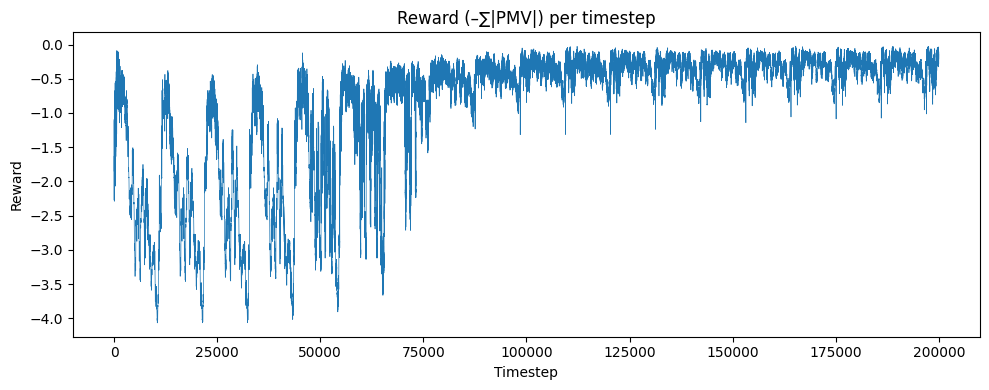

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Cargar datos guardados
data = np.load("logs/step_rewards_real.npz")
timesteps = data["timesteps"]
rewards   = data["raw_rewards"]

# Graficar
plt.figure(figsize=(10,4))
plt.plot(timesteps, rewards, linewidth=0.5)
plt.title("Reward (–∑|PMV|) per timestep")
plt.xlabel("Timestep")
plt.ylabel("Reward")
plt.tight_layout()
plt.show()

In [3]:
model.save('/home/jovyan/controller_notebooks/test1_agent')
env.save('/home/jovyan/controller_notebooks/test1_agent_vecnormalize.plk')